# Quantum Machine Learning Using Variational Circuits
This article is a part of the final project at the Womanium Quantum + AI Scholarship Program, where we will dive into the world of Quantum Machine Learning. The only prerequisite here is a previous knowledge of the basics of Machine Learning and the fundamentals of Quantum Computing, as we will try to simplify the notions.

## What is Quantum Machine Learning?
The main difference between QML and its classical counterparts is that it uses the principles of quantum computing to write a specific set of quantum algorithms that simulate the behavior, flow, and concepts of classical Machine Learning using quantum hardware. These algorithms can be executed on classical data (after some transformations, which we will tackle in the next sections) or on a quantum data set.

We should mention that this field is in its early stages and as a dynamic area of research, many questions are still under investigation, and many constraints are slowing down the process, such as the current limited quantum devices.

## How can we emulate Classical Machine Learning on a Qunatum Device?
Before delving into the concepts of QML we need to define the idea of a Variational Quantum Circuit that will often be used during this article:

### The Variational Quantum Circuit:
Also called Parameterized Quantum Circuits or Ansatz are quantum circuits where some of the gates are tunable and depend on some parameters.

The following figure shows a simple variational circuit with a parameterized Unitary gate $U$ with its tunable parameter $\theta$  

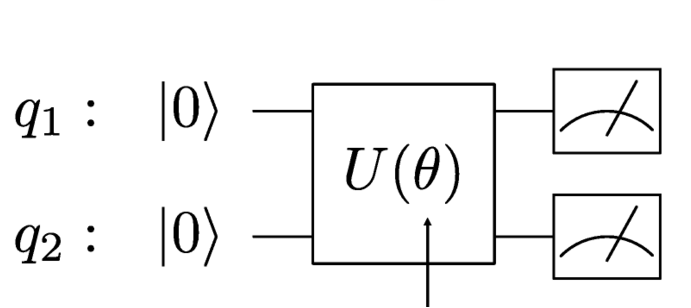

_Fig 1: Schematisation of a simple variational quantum circuit_

_Credit: The Article: "Kernel methods in Quantum Machine Learning" {Riccardo Mengoni & 
Alessandra Di Pierro_}

### The Relation with Classical Machine Learning:

Anyone with basic knowledge of machine learning can connect the dots between the QML and the Variational Circuits when hearing "tunable parameters", whereas, in the classical approach, models are trained by updating their weights to minimize the cost function. Similarly, in the quantum approach, parameters of variational gates are optimized after the measurement to achieve better accuracy.

### The Flow of Quantum Machine Learning:

We will discuss each of these steps in detail during this article, but for now, we need to familiarize ourselves with the general image of the workflow.

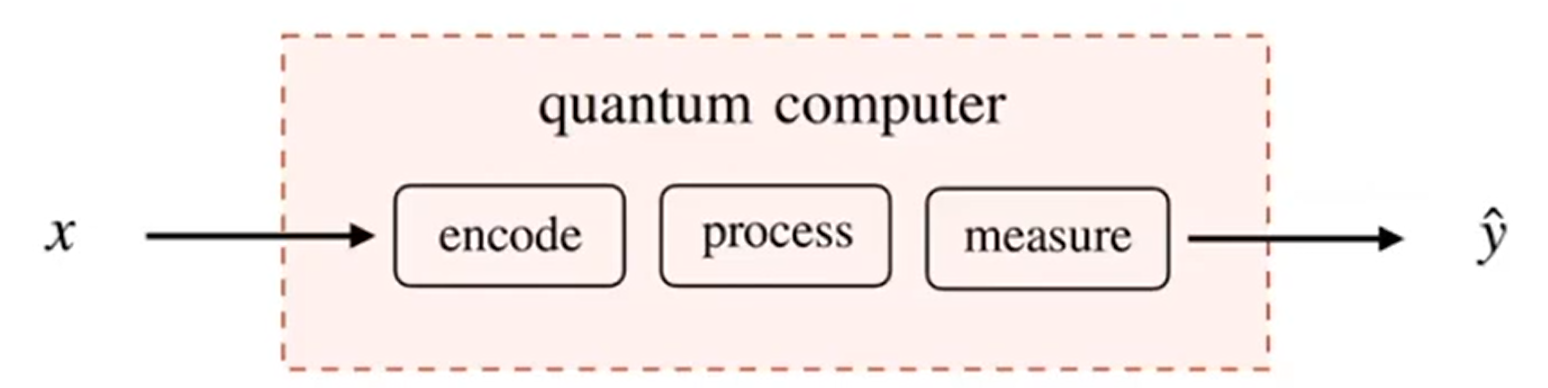

_Fig 2: The QML Flow_

_Credit: Maria Schuld_

As we can see in this abstract schematization of the QML flow on a quantum computer, the input classical data $x$ goes through the following steps to achieve the desired output $\hat{y}$, which can be a label or anything else according to the QML task:

- **Step 1: Encoding:** As we are dealing with a quantum computer, classical data can't enter the quantum device without getting encoded in a manner that suits its quantum nature. Several methods can be applied for this step, such as _Basis Encoding_, _Amplitude Encoding_, _Angle Encoding_, and Higher Order Encoding. We will explain some of them in the following examples.

- **Step 2: Processing:** involves applying a variational circuit with its adjustable parameters (generally randomly initialized in the first training iteration). This step will then be repeated by optimizing the parameters, similar to how _weights_ are trained in the classical models.

- **Step 3: Measuring:** We want to extract the results of our model processing in an interpretable way according to our task. This can be done using several methods and applying them repeatedly, known as the number of _shots_ (where in each shot, the quantum state collapses into one and only one classical state) to get a probability distribution of a specific set of basis states from which we can extract our desired $\hat{y}$

### How can we optimize our variational unitary?

In the supervised classical flow, after a model makes its prediction or performs its calculations on a data set, the results are then compared with the true ones, and a cost function is calculated, generally with this formula $C$ that depends on the weights vector $w$: $\begin{equation} C(w) = \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_i(w) - y_i \right)^2 \end{equation}$

where $N$ is the number of the training samples, $\hat{y}$ is the predicted outputs by the model, and $y$ is the correct answer or result.

by changing these weights, we aim to minimize this cost function by looking for one of its local minimums and nothing is more helpful in doing this than the _gradient descent_. The weights are updated according to the rule: $\begin{equation} w \leftarrow w - \eta \nabla_w C(w) \end{equation}$ with $\eta$ is the learning rate hyperparameter (a small number to control the learning speed). The gradient descent $\nabla_w C(w)$ is a vector of the partial derivatives of the cost function according to each parameter $w$

The optimization of the variational parameters of our unitary in our quantum circuit is the same as what we mentioned above just considering the weights as the parameters $\theta$ after the predictions $\hat{y}$ are calculated:



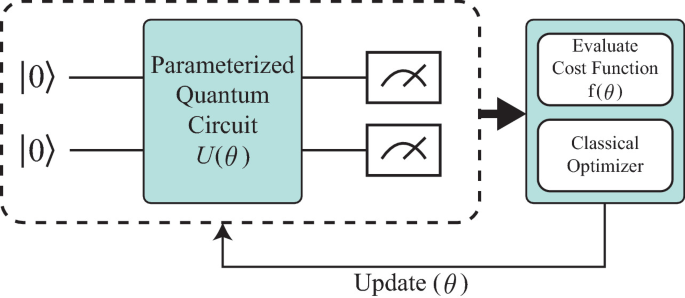

_Fig3: The Flow of the variational circuit used in QML with a classical optimizer_

_Credit: Conf Paper: Neural Networks with Variational Quantum Circuits of Syed Muhammad Abuzar Rizvi, Muhammad Shohibul Ulum, Naema Asif & Hyundong Shin

## Example 01: Simple Quantum Variational Classifier

A classifier is a model that performs a classification task, where it associates with each data sample a label from the task classes.
in this example, we will build a quantum model that classifies a set of binary strings of 4 bits according to the parity of the 1's in it according to the following function: 

$\begin{equation} \begin{split}f: x \in \{0,1\}^{\otimes 4} \rightarrow y = \begin{cases} 1 \text{ if an odd number of 1's in } x \\ 0 \text{ else}. \end{cases}\end{split} \end{equation}$

eg. the string **$1001$** contains 2 ones (an **even** number) so the parity function result must give $1$

for this task, we will use **pennylane** a quantum software framework provided by **Xanadu**

we first start by doing the necessary imports:


In [1]:
import pennylane as qml #The Pennylane library
from pennylane import numpy as np #The version of numpy related to Pennylane
from pennylane.optimize import NesterovMomentumOptimizer #An optimizer, we will also try to build ours
import matplotlib.pyplot as plt

Using pennylane we need to create a device that will run our quantum code:

In [2]:
dev = qml.device("default.qubit", wires = 4)

Following the steps of the QML flow the first thing we have to do is to find a method to **encode** our data into the quantum device, since our data samples are bit strings we can easily encode them using the _Basis Encoding_ method, so our quantum state  $\psi$ will contain our information e.g if the data sample is $0011$ than $|\psi\rangle = |0011\rangle$

to achieve this encoding we can use the Pennylane method BasisState:

In [3]:
def State_Preparation(BitString):
    qml.BasisState(BitString, wires=[0, 1, 2, 3])

The second step consists of the processing or the variational unitary operations which is similar to the classical model where the data go through, for this step, we have several models of our blocks which are repeated several sequential times in what's called **layers**

A basic model block can be a set of rotation parametrized gates (in the three axes x, y, and z) applied on all qubits followed by an entanglement CNOT gates as we can see below

In [4]:
def layer_xyz(layer_weights):
    for wire in range(4):
        qml.RX(layer_weights[wire][0], wires=wire)
        qml.RY(layer_weights[wire][1], wires=wire)
        qml.RZ(layer_weights[wire][2], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)


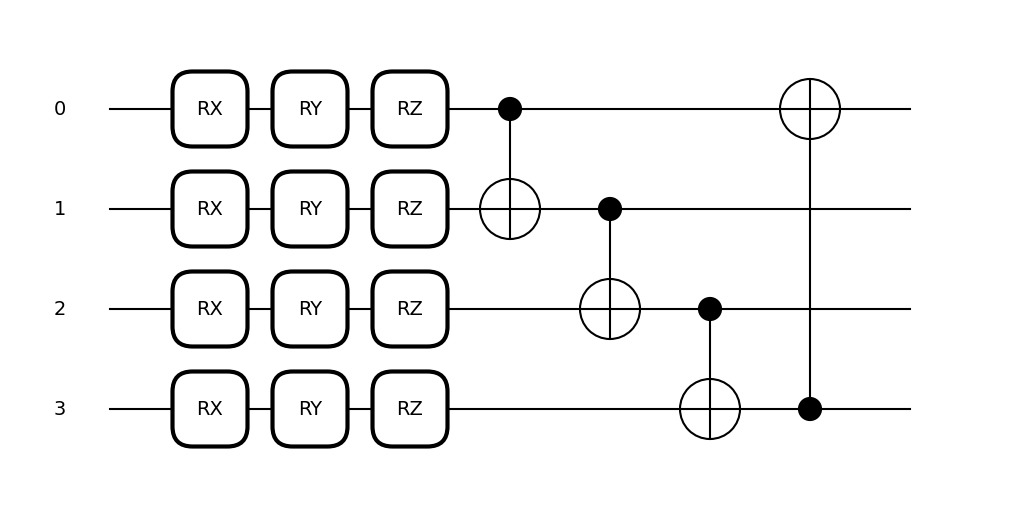

_Fig3: Elementary layer of the variational model generated from the above source code with arbitrary weights_

To simplify the circuit, we can use the ROT gate, which applies a rotation on the 3 axes by taking 3 parameters as input at once, these parameters will be referred to as _weights_.

In [5]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

We can now create our circuit, we also add another trainable parameter called the bias to give our model a certain degree of freedom especially when the data do not intercept with the 0.
For the 3rd step which is measuring and extracting the label from the circuit so we can use it later for optimization, we will calculate the expected value of the circuit using the Z gate which maps the results into values between $-1$ and $+1$ (its eigenvalues) 

In [6]:
@qml.qnode(dev)
def VariationalClassifier_without_bias(weights, x):
    State_Preparation(x)

    for layer_weights in weights:
        layer(layer_weights)
  
    return qml.expval(qml.PauliZ(0)) #To calculate the expected value


def VariationalClassifier(weights, bias, x):
    return VariationalClassifier_without_bias(weights, x) + bias

We must declare the two functions above separately because a quantum function must return a measurement instance.

We will now define and randomly initialize the weights data structure and the bias, and also define the number of layers (we will take it 2 since the classification task is simple)

(<Figure size 1400x500 with 1 Axes>, <Axes: >)


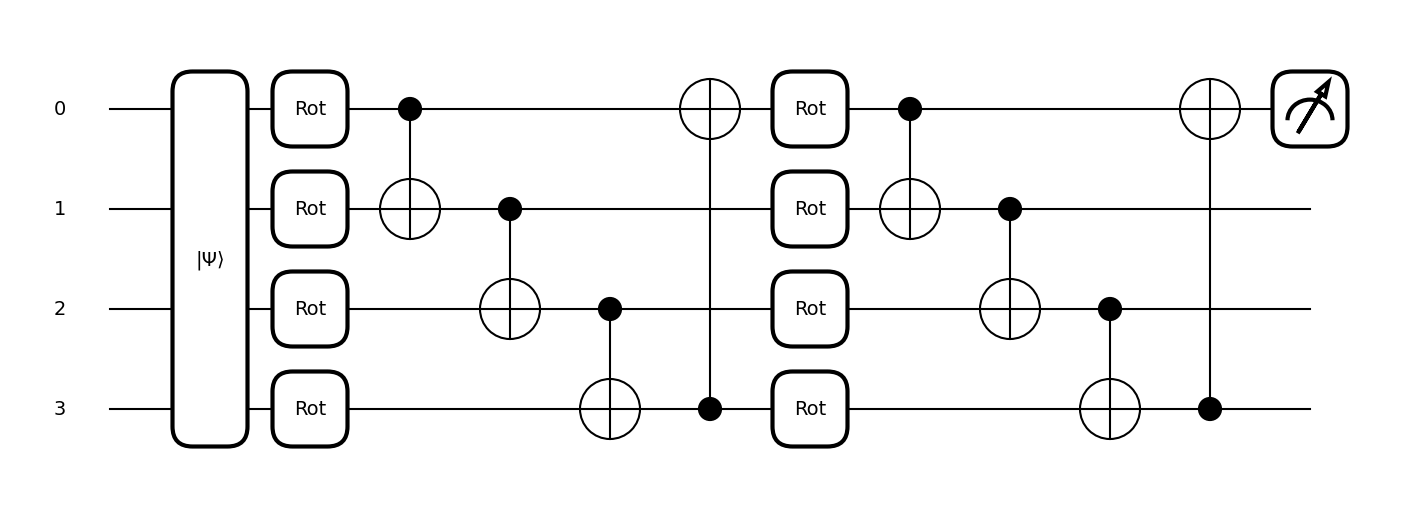

In [7]:
num_layers = 2

np.random.seed(0) #To ensure we will have the same random results every time

weights = 0.01 * np.random.randn(num_layers, 4, 3, requires_grad=True) #randn => to return results from the “standard normal” distribution.
                                                                                #requires_grad => gradients need to be computed for this Tensor.

bias = np.array(0.0, requires_grad=True)

drawer1 = qml.draw_mpl(VariationalClassifier_without_bias) #We Can't draw the circuit with bias because it's not a quantum circuit
print(drawer1(weights, [0,0,1,1]))

_Fig 4: The Quantum Circuit with Basis States encoding and 2 layers of processing_

In [8]:
drawer2 = qml.draw(VariationalClassifier_without_bias)
print(drawer2(weights, [0,0,1,1]))

0: ─╭|Ψ⟩──Rot(0.02,0.00,0.01)───╭●───────╭X──Rot(0.01,0.00,0.00)───╭●───────╭X─┤  <Z>
1: ─├|Ψ⟩──Rot(0.02,0.02,-0.01)──╰X─╭●────│───Rot(0.00,0.01,-0.00)──╰X─╭●────│──┤     
2: ─├|Ψ⟩──Rot(0.01,-0.00,-0.00)────╰X─╭●─│───Rot(0.00,-0.01,-0.03)────╰X─╭●─│──┤     
3: ─╰|Ψ⟩──Rot(0.00,0.00,0.01)─────────╰X─╰●──Rot(0.01,0.01,-0.01)────────╰X─╰●─┤     


_Fig 5: The Quantum Circuit printed in a way that the weights' values can be read_


Now we have our circuit, we will write the code for the optimization matrices: The Accuracy and the cost function.

N.B: The cost function => $\begin{equation} C(w) = \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_i(w) - y_i \right)^2 \end{equation}$

The Accuracy => $\text{Accuracy} = \frac{\text{Number of Correct Predictions (With tolerance)}}{\text{Total Number of Predictions}}$


In [9]:
def Accuracy(true_labels, predictions):
    sum = 0
    for l, p in zip(true_labels, predictions):
        if abs(l - p) < 0.00001: #The error tolerance
            sum += 1
    accuracy = sum / len(true_labels)
    return accuracy


def Cost(weights,bias, X, true_labels):
    predictions = [VariationalClassifier(weights, bias, x) for x in X] #qml.math.stack to stack the predictions in the tensor format
    cost = np.mean(true_labels- qml.math.stack(predictions))**2
    
    return cost
    

Now we need an optimizer

In [10]:
optimizer = NesterovMomentumOptimizer(0.5) # 0.5 is the step size

In [11]:

train_data = np.array([
    [0, 0, 0, 1, 1],
    [0, 0, 1, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 1, 0, 1, 0],
    [0, 1, 1, 0, 0],
    [0, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 0, 0, 1, 0],
    [1, 0, 1, 1, 1],
    [1, 1, 1, 1, 0]
])

test_data = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0],
    [1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1],
    [1, 1, 0, 0, 0],
    [1, 1, 0, 1, 1]
])


X_train = train_data[:, :-1]
Y_train = train_data[:, -1]
Y_train = Y_train * 2 - 1  # shift labels from {0, 1} to {-1, 1}


X_test = test_data[:, :-1]
Y_test = test_data[:, -1]
Y_test = Y_test * 2 - 1  # shift labels from {0, 1} to {-1, 1}




Next, we will  go through our dataset with a batch of 5 samples repeat the optimization and processing step 100 times (epochs), and calculate the cost and accuracy

In [12]:
batch_size = 5
costs = []
accuracies = []
for iter in range(100):

    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    
    weights, bias = optimizer.step(Cost, weights, bias, X = X_batch, true_labels = Y_batch)
    
    predictions = [np.sign(VariationalClassifier(weights, bias, x)) for x in X_train]
    
    current_cost = Cost(weights, bias, X_train, Y_train)
    
    acc = Accuracy(Y_train, predictions)
    costs.append(current_cost)
    accuracies.append(acc)
    print(f"Iter: {iter+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")


Iter:    1 | Cost: 0.3597346 | Accuracy: 0.5000000
Iter:    2 | Cost: 0.0401075 | Accuracy: 0.5000000
Iter:    3 | Cost: 0.0397156 | Accuracy: 0.5000000
Iter:    4 | Cost: 0.9978163 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.0392298 | Accuracy: 0.5000000
Iter:    6 | Cost: 0.0321990 | Accuracy: 0.5000000
Iter:    7 | Cost: 0.3600173 | Accuracy: 0.5000000
Iter:    8 | Cost: 0.9963098 | Accuracy: 0.5000000
Iter:    9 | Cost: 0.0405706 | Accuracy: 0.5000000
Iter:   10 | Cost: 0.0404836 | Accuracy: 0.5000000
Iter:   11 | Cost: 0.3490839 | Accuracy: 0.5000000
Iter:   12 | Cost: 0.0360124 | Accuracy: 0.5000000
Iter:   13 | Cost: 0.3367181 | Accuracy: 0.5000000
Iter:   14 | Cost: 0.3294666 | Accuracy: 0.5000000
Iter:   15 | Cost: 0.0218297 | Accuracy: 0.5000000
Iter:   16 | Cost: 0.0960697 | Accuracy: 0.6000000
Iter:   17 | Cost: 0.7117056 | Accuracy: 0.6000000
Iter:   18 | Cost: 0.8523317 | Accuracy: 0.6000000
Iter:   19 | Cost: 0.1533487 | Accuracy: 0.6000000
Iter:   20 | Cost: 0.3880906 | 

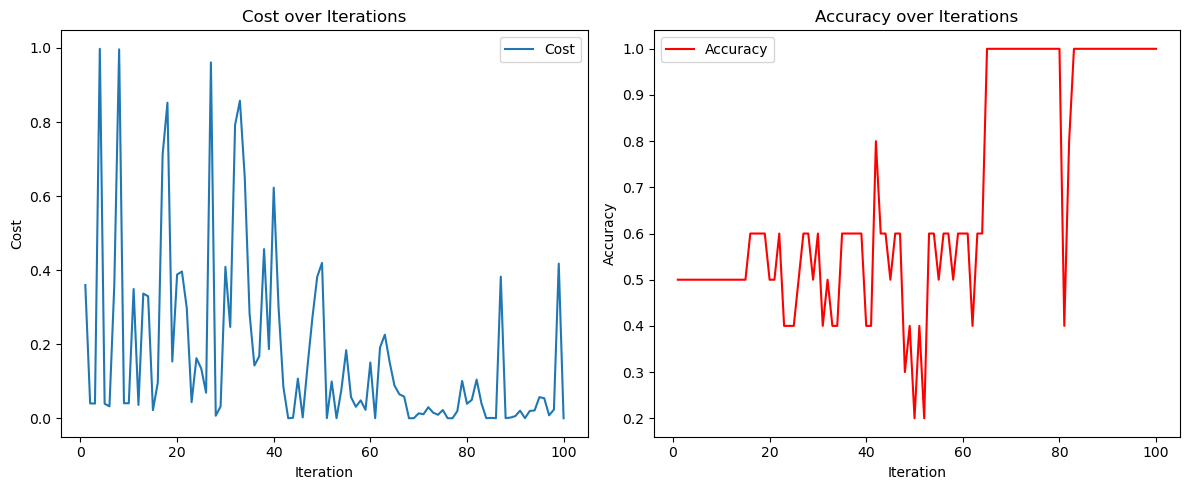

In [13]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 101), costs, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost over Iterations')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, 101), accuracies,c = 'r', label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy over Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Now we want to test our model on another unseen dataset to make sure that the model is not **overfitted** on the training data, we can test it on the _X_test_ data

In [14]:
predictions_test = [np.sign(VariationalClassifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    s = '' if y == -1 else ' '
    print(f"Data = {x}| Correct Label = "+ s + f"{y} | Predicted Label = "+ s + f"{p}")



acc_test = Accuracy(Y_test, predictions_test)
print("\nAccuracy on unseen data:", acc_test)

Data = [0 0 0 0]| Correct Label = -1 | Predicted Label = -1.0
Data = [0 0 1 1]| Correct Label = -1 | Predicted Label = -1.0
Data = [1 0 1 0]| Correct Label = -1 | Predicted Label = -1.0
Data = [1 1 1 0]| Correct Label =  1 | Predicted Label =  1.0
Data = [1 1 0 0]| Correct Label = -1 | Predicted Label = -1.0
Data = [1 1 0 1]| Correct Label =  1 | Predicted Label =  1.0

Accuracy on unseen data: 1.0


And here we are, our model perfectly predicted the correct labels. We can say that it learned our _parity function_ without any knowledge except the correctly labeled and seen data.

## Example 02: Another Quantum Variational Classifier:

We will try to implement the previous model for another task using another way of encoding, now we have to classify the iris data set into two classes of flowers.

The encoding method we will use is called **Amplitude Encoding** where the data vector is encoded into the amplitude of the quantum state. Our data has 4 features, so we can use 2 qubits to represent them through the amplitude encoding (4 Basis states each state represents a feature), to achieve this we need first to get the angles and then apply some rotations and controlled gates as mentioned in the following paper [Transformation of quantum states using uniformly controlled rotations](https://arxiv.org/abs/quant-ph/0407010)

In [42]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def State_Preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Now we update the layers function since our circuit has only 2 qubits.
For the Cost function, we should transpose the input matrix from $(n_{\text{samples}}, n_{\text{features}})$ to $(n_{\text{features}}, n_{\text{samples}})$, this allows us to pass each data sample (column of X.T) to the state preparation function

In [43]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])



def cost(weights,bias, X, true_labels):
    predictions = [VariationalClassifier(weights, bias, x.T) for x in X] #qml.math.stack to stack the predictions in the tensor format
    cost = np.mean(true_labels- qml.math.stack(predictions))**2
    
    return cost

Now we load our data, we will select two features (the more informative) as a preprocessing step and then we will pad the vectors with 2 constants so we can match the quantum state vector size, then we will normalize our inputs so we can get the angles and consider them as our _features_

In [20]:
data = np.loadtxt("iris.txt")
X = data[:, 0:4]
print(f"First X sample (original)  : {X[0]}")

#Padding
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# The angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75 0.2  0.05]
First X sample (padded)    : [0.4  0.75 0.2  0.05 0.1  0.1 ]
First X sample (normalized): [0.45146612 0.84649897 0.22573306 0.05643326 0.11286653 0.11286653]
First features sample      : [ 0.57210288 -0.24497866  0.24497866 -1.080839    1.080839  ]


Now we split our data into training and testing sets

In [24]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

We redefine our weights, bias, and number of layers (6 here since our task is more complicated)

In [25]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

Like what we did in the first example, we launch the optimizer on the Variational Classifier in order to optimize the cost function

In [48]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

iterations = []
costs = []
acc_train_list = []
acc_val_list = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(VariationalClassifier(weights, bias, feats_train.T))
    predictions_val = np.sign(VariationalClassifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = Accuracy(Y_train, predictions_train)
    acc_val = Accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        iterations.append(it + 1)
        costs.append(_cost)
        acc_train_list.append(acc_train)
        acc_val_list.append(acc_val)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 0.0257275 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:     4 | Cost: 0.0426345 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:     6 | Cost: 0.0239324 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:     8 | Cost: 0.0488744 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    10 | Cost: 0.0299043 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    12 | Cost: 0.0090316 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    14 | Cost: 0.0154003 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    16 | Cost: 0.0160238 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    18 | Cost: 0.0036852 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    20 | Cost: 0.0064254 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    22 | Cost: 0.0015268 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    24 | Cost: 0.0365626 | Acc train: 0.0133333 | Acc validation: 0.0000000
Iter:    26 | Cost: 0.034254

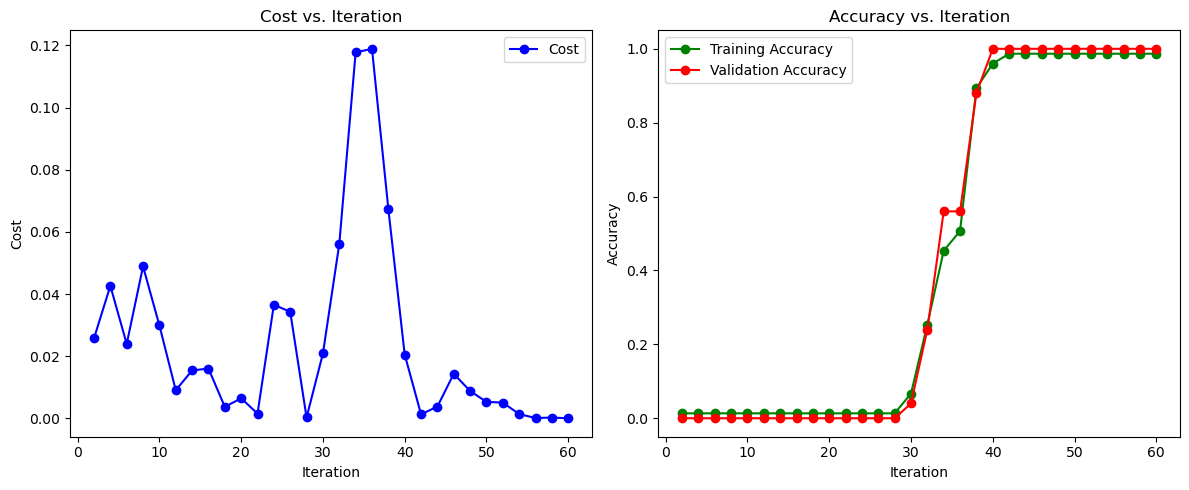

In [49]:
# Plot cost over iterations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(iterations, costs, marker='o', color='b', label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs. Iteration')
plt.legend()

# Plot accuracy over iterations
plt.subplot(1, 2, 2)
plt.plot(iterations, acc_train_list, marker='o', color='g', label='Training Accuracy')
plt.plot(iterations, acc_val_list, marker='o', color='r', label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration')
plt.legend()

plt.tight_layout()
plt.show()


As we can see, our model perfectly learned to predict the correct labels on the seen data and generalize it to unseen data by minimizing the objective function.

## Conclusion:

Variational Classifiers, which use variational circuits in quantum machine learning tasks, provide a valuable starting point for those looking to explore this field. Their parameterized nature makes them suitable for modeling classical machine learning processes through the steps of encoding, processing, measuring, and optimizing.

As demonstrated in this notebook, the results of quantum machine learning are promising. However, significant research and development are needed to realize the full potential of QML and to achieve outcomes that surpass those of classical counterparts.